В данном файле реализуем обучение пары моделей сверточных нейросетей.  
- В одном случае напишем архитектуру и обучим модель самостоятельно.
- В другом случае реализуем transfer learning для одной из «легких» моделей (MobileNet_V2) обученных на ImageNet-1K.

**Подготовительные действия**  
Обучение моделей будем проводить в Google Colab.  
Необходимо загрузить на Гугл Диск ранее подготовленный датасет из картинок `Pic_for_CNN`.  
На страничке Диска выбрать Создать --> Загрузить папку --> (указать путь к папке  Pic_for_CNN)

### Этап 1. Подготовка и основные функции НС  
На данном этапе импортируем нужные библиотеки, сделаем преобразования с датасетом и пропишем основные функции НС.

In [1]:
import warnings

import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms.v2 as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from tqdm import tqdm

warnings.filterwarnings('ignore')

plt.rc('font', size=15)

In [2]:
import random

seed = 65
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
# Тут необходимо дать разрешения для работы с гугл диском
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_root = '/content/drive/My Drive/Pic_for_CNN/'
print(os.listdir(data_root))

['test', 'validation', 'train']


In [6]:
train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'validation')

In [7]:
train_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(train_dir, train_transforms)
val_dataset = ImageFolder(val_dir, val_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

In [8]:
len(train_loader), len(train_dataset)

(100, 1588)

In [9]:
len(valid_loader), len(valid_loader)

(84, 84)

In [10]:
train_dataset.classes

['1_buy', '2_nothing', '3_sell']

In [11]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer
from tqdm import tqdm


def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn, device: torch.device):
    model.train()

    total_loss = 0
    total_correct = 0

    for x, y in tqdm(data_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()

        total_correct += (output.argmax(dim=1) == y).sum().item()

        optimizer.step()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device):
    model.eval()

    total_loss = 0
    total_correct = 0

    for x, y in tqdm(data_loader):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        total_correct += (output.argmax(dim=1) == y).sum().item()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

def plot_stats(train_loss: list[float], valid_loss: list[float],
               train_accuracy: list[float], valid_accuracy: list[float],
               title: str):
    plt.figure(figsize = (13, 4))

    plt.subplot(1, 2, 1)
    plt.title(title + ' loss')
    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(title + ' accuracy')
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.show()

In [14]:
from IPython.display import clear_output

def fit(model, train_loader, valid_loader, optimizer, loss_fn, device, num_epochs, title, scheduler=None):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        if scheduler is not None:
            scheduler.step()

На этом первый этап завершен.

### Этап 2. Обучение моделей.

### Первая модель  
Для первой модели - `FirstModel` создадим упрощенную архитектуру. Просто для того, чтобы затем сравнить результаты с тем, что покажет transfer learning  MobileNet_V2

In [15]:
class FirstModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            # Block 1: 224x224 -> 112x112
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # (16, 224, 224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (16, 112, 112)

            # Block 2: 112x112 -> 56x56
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # (32, 112, 112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (32, 56, 56)

            # Block 3: 56x56 -> 28x28
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # (64, 56, 56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (64, 28, 28)

            # Block 4: 28x28 -> 14x14
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # (128, 28, 28)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (128, 14, 14)

            # Global pooling and classifier
            nn.AdaptiveAvgPool2d(1),  # (128, 1, 1)
            nn.Flatten(),             # 128
            nn.Dropout(0.2),          # Dropout для регуляризации
            nn.Linear(128, 3)         # 3 classes
        )

    def forward(self, x):
        return self.net(x)

In [16]:
from torch.optim import Adam
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = FirstModel().to(device)
optimizer = Adam(model.parameters(), lr=0.003)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

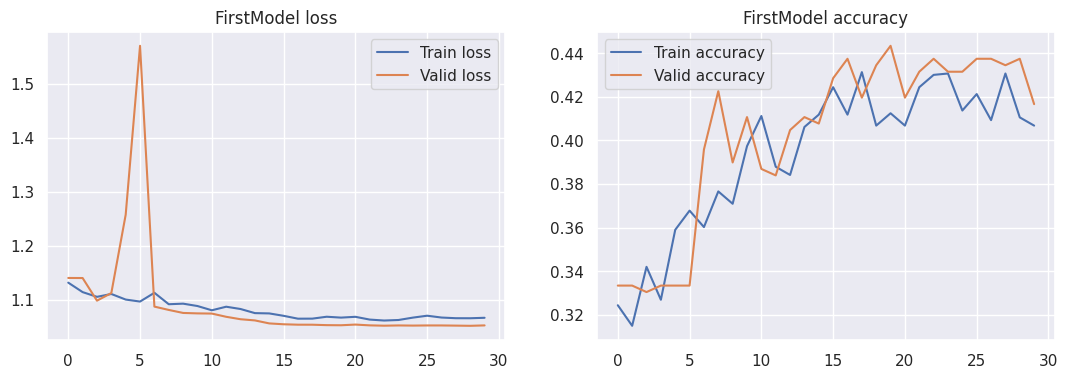

In [17]:
fit(model, train_loader, valid_loader, optimizer, loss_fn, device, 30, 'FirstModel', scheduler)

В ходе нескольких процедур формирования картинок и нескольких запусков обучения НС результаты accuracy колеблются от 38% до 44% в зависимости от благосклонности рандома.

### Вторая модель

Для второй модели, назовем ее - **MobileNet_V2 Classifier defrost**, реализуем transfer learning.  
Подгрузим ее архитектуру и параметры, а также разморозим ее последний слой - classifier.

In [25]:
from torchvision.models import mobilenet_v2
from torchvision.models import MobileNet_V2_Weights

In [26]:
from torch.optim import Adam
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)
# Заменяем исходную голову (классификатор) модели на голову с правильным числом классов
model.classifier[1] = torch.nn.Linear(1280, len(train_dataset.classes))
model = model.to(device)

model.requires_grad_(False)
model.classifier.requires_grad_(True)

optimizer = Adam([p for p in model.parameters() if p.requires_grad], lr=0.003)

loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

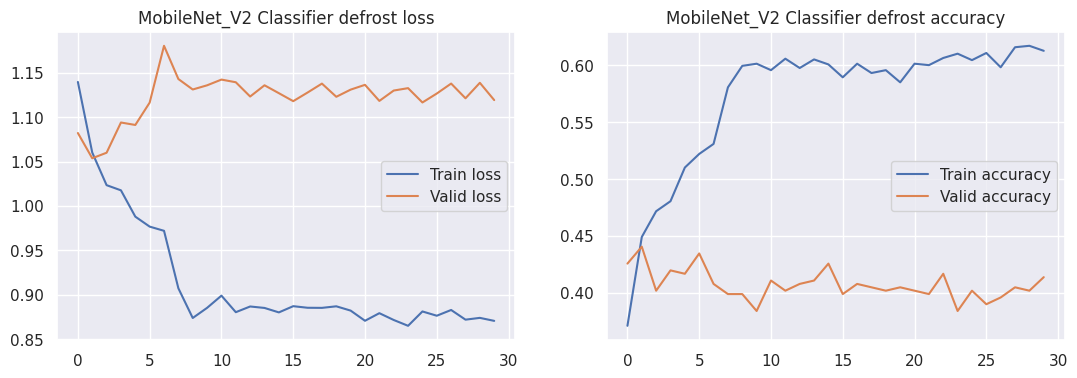

In [27]:
fit(model, train_loader, valid_loader, optimizer, loss_fn, device, 30,
    'MobileNet_V2 Classifier defrost', scheduler)

Вторая модель показала примерно тот же результат. С той лишь особенностью, что она немного более стабильна на протяжении нескольких попыток запусков. Вместе с тем, данная конфигурация более склонна к переобучению, поскольку наш датасет это довольно простые картинки, а архитектура данной модели все-же настроена под более сложные задачи.

В данном проекте не задействуем тестовую часть нашего датасета, поскольку на данном этапе развития этого проекта (для такого скромного accuracy) это не имеет большого смысла. 

**Общий итог:**  
- Это был экспериментальный проект с целью оценить возможности классификации будущих приращений котировок, используя для этого сверточные нейросети.
- Непосредственно в данной конфигурации (логика классификации, рисование и отбор изображений и тд) можно получить довольно скромные результаты accuracy на уровне 40-45%, что примерно лишь на 10% выше случайных (33% для 3-х классовой классификации).
- Тем не менее, это был интересный опыт анализа реальных, очень сложных для выявления закономерностей данных. 